### Navier-Stokes fluid flow Direct FEM Simulation (DFS)



*Note: This is a modified version of a flow problem in [MOOC-HPFEM](https://github.com/johanjan/MOOC-HPFEM-source/blob/master/MOOC_HPFEM_Fluid.ipynb) course. This modification only wants to illustrate a flow problem simulation and does not claim any copyright!*

<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight: <span class="math display">\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  u_t + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
\hat{u} &=& (u, p), \quad r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v}) \quad (\text{Weak residual})
\end{array}</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with GLS stabilization. Developed over 20+ years by Johnson, Hoffman, Jansson, etc.</dt>
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}</span></p>
</dd>

We will simulate the flow past a cylinder following this experiement: https://www.youtube.com/watch?v=hrX11VtXXsU

### FEniCS DFS formulation to run and modify yourself

Modified Code

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display, update_display; import time; import dolfin.common.plotting as fenicsplot 
import time

def plot_compact(u, t, stepcounter, QQ, pl, ax): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("Velocity at t=%f" % (t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); plt.colorbar(pp, shrink=0.5); 
    plt.subplot(1, 2, 2);
    if t == 0.: plot(Q.mesh()); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.2; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=20 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(0.5, 0.5*(YMIN+YMAX)), .2, mresolution), mresolution)


1. Without refinement and $Re = 10$

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


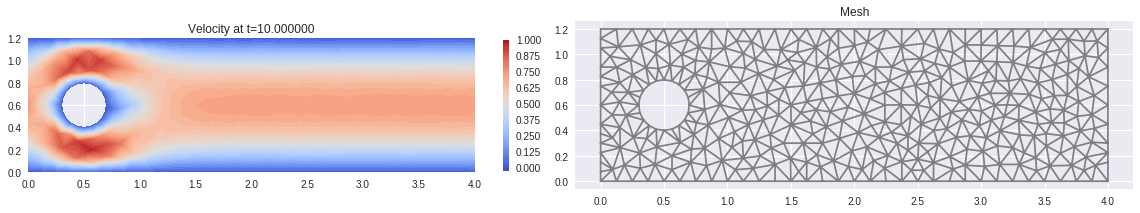

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


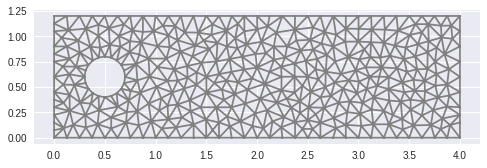

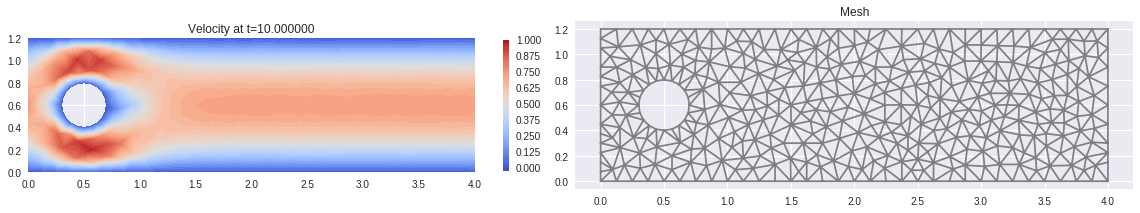

In [13]:
VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Mark regions for boundary conditions
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element())
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element())

stepcounter = 0; pl = None; ax = None

plot(mesh)
# Copyright (c) 2017-2018 Johan Jansson, Cem Degirmenci and David Kamensky 

k = 0.1; nu = 1e-1; d = .3*h**(3./2.) # Timestep, viscosity and stabilization parameters
t, T = 0., 10.; gamma = 10*1./h # Time interval and penalty parameter

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
  um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
  r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
       gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
      d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
  solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
  pl, ax = plot_compact(u, t, stepcounter, Q, pl, ax) # Plot all quantities (see implementation above)
  t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep


2. Without refinement and $Re = 100$

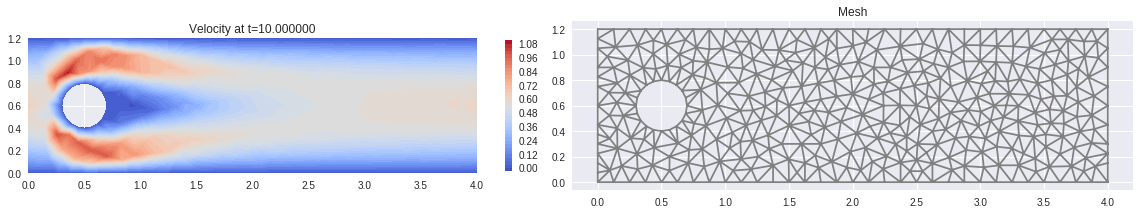

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


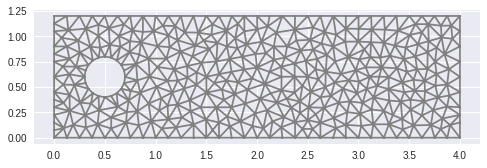

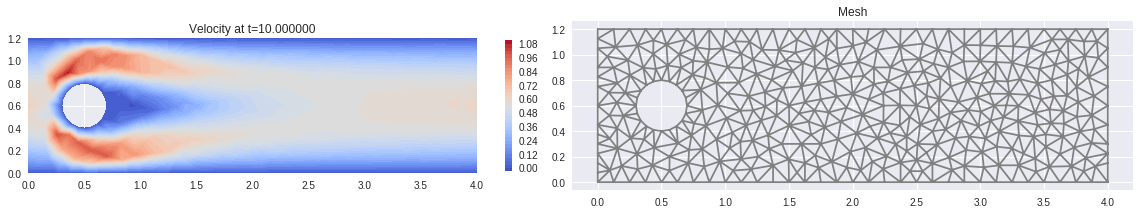

In [14]:
VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Mark regions for boundary conditions
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element())
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element())

stepcounter = 0; pl = None; ax = None

plot(mesh)

# Copyright (c) 2017-2018 Johan Jansson, Cem Degirmenci and David Kamensky 

k = 0.1; nu = 1e-2; d = .3*h**(3./2.) # Timestep, viscosity and stabilization parameters
t, T = 0., 10.; gamma = 10*1./h # Time interval and penalty parameter

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
  um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
  r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
       gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
      d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
  solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
  pl, ax = plot_compact(u, t, stepcounter, Q, pl, ax) # Plot all quantities (see implementation above)
  t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep

3. With refinement and $Re = 10$

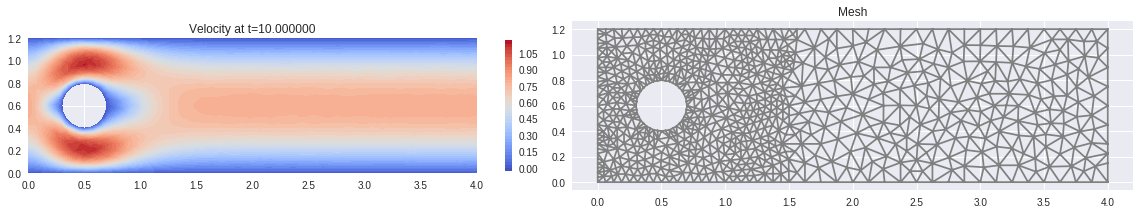

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


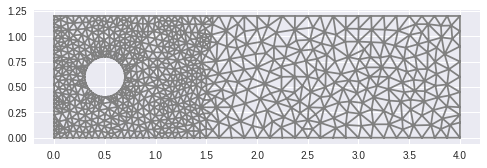

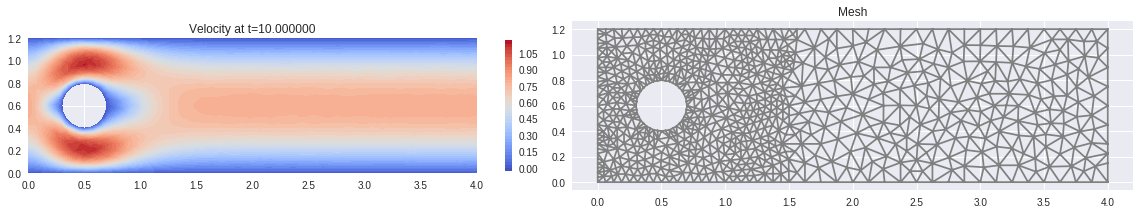

In [15]:
XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.2; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=20 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(0.5, 0.5*(YMIN+YMAX)), .2, mresolution), mresolution)

## local refinement
# cell_markers = CellFunction("bool", mesh)
for i in range(0,1):
  cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_markers[cell] = False
    p = cell.midpoint()
    if p.x()<1.5:
        cell_markers[cell] = True
  mesh = refine(mesh, cell_markers)
  
VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Mark regions for boundary conditions
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element())
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element())

stepcounter = 0; pl = None; ax = None

plot(mesh)

XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.2; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=20 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(0.5, 0.5*(YMIN+YMAX)), .2, mresolution), mresolution)


# Copyright (c) 2017-2018 Johan Jansson, Cem Degirmenci and David Kamensky 

k = 0.1; nu = 1e-1; d = .3*h**(3./2.) # Timestep, viscosity and stabilization parameters
t, T = 0., 10.; gamma = 10*1./h # Time interval and penalty parameter

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
  um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
  r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
       gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
      d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
  solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
  pl, ax = plot_compact(u, t, stepcounter, Q, pl, ax) # Plot all quantities (see implementation above)
  t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep

4.  With refinement and $Re = 100$


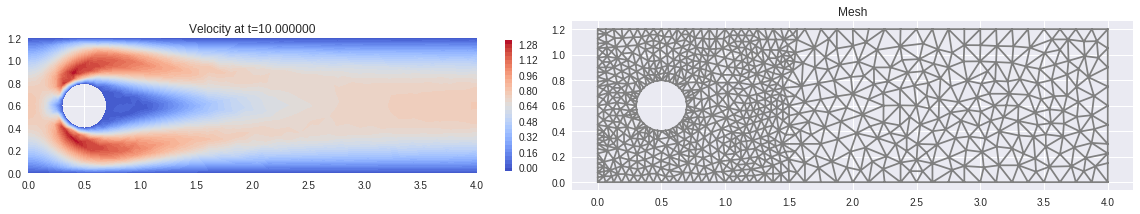

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


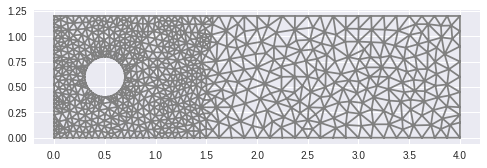

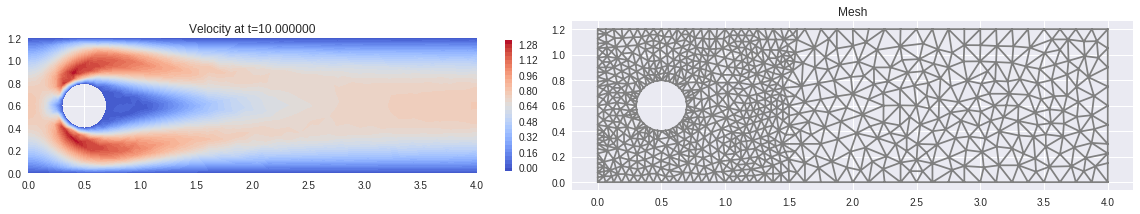

In [16]:
XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.2; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=20 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(0.5, 0.5*(YMIN+YMAX)), .2, mresolution), mresolution)

## local refinement
# cell_markers = CellFunction("bool", mesh)
for i in range(0,1):
  cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_markers[cell] = False
    p = cell.midpoint()
    if p.x()<1.5:
        cell_markers[cell] = True
  mesh = refine(mesh, cell_markers)
  
VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1); h = CellDiameter(mesh); # FEM functions
WE = VE * QE; W = FunctionSpace(mesh, WE); V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE) # Make a mixed space
(v, q) = TestFunctions(W); w = Function(W); (u, p) = (as_vector((w[0], w[1])), w[2]); u0 = Function(V)

uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) # Inflow velocity
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, element = Q.ufl_element()) # Mark regions for boundary conditions
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, element = Q.ufl_element())
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, element = Q.ufl_element())

stepcounter = 0; pl = None; ax = None

plot(mesh)

XMIN = 0.; XMAX = 4; YMIN = 0; YMAX = 1.2; G = [XMIN, XMAX, YMIN, YMAX]; eps = 1e-5; mresolution=20 # Geometry and mesh
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(0.5, 0.5*(YMIN+YMAX)), .2, mresolution), mresolution)


# Copyright (c) 2017-2018 Johan Jansson, Cem Degirmenci and David Kamensky 

k = 0.1; nu = 1e-2; d = .3*h**(3./2.) # Timestep, viscosity and stabilization parameters
t, T = 0., 10.; gamma = 10*1./h # Time interval and penalty parameter

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
  um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.
  r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
       gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
      d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
  solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
  pl, ax = plot_compact(u, t, stepcounter, Q, pl, ax) # Plot all quantities (see implementation above)
  t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep